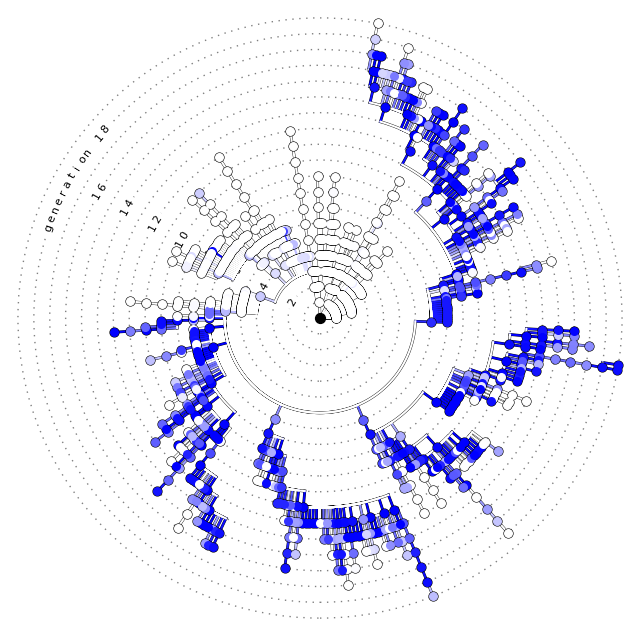

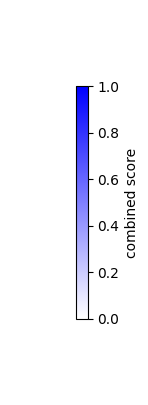

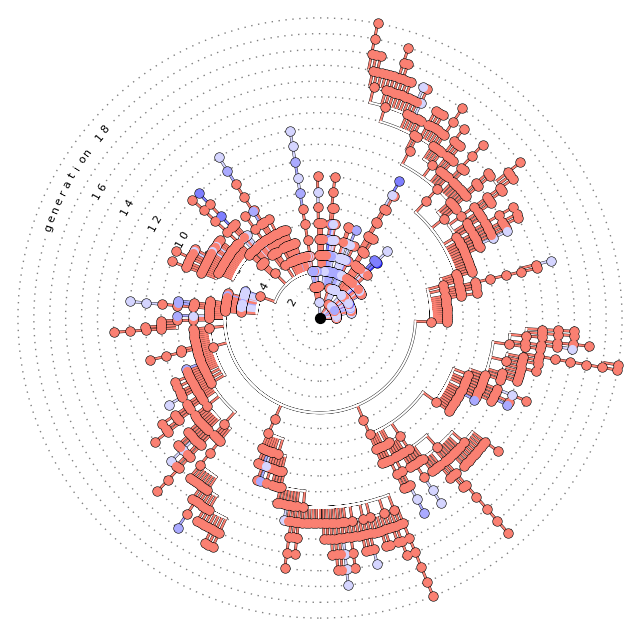

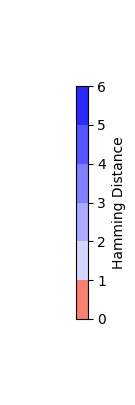

In [149]:
def plot_tree(self, max_generation=0, radius_offset=0, max_angle=360, color="hamming_distance", generation_labels=None, start_angle_label=0):
    import matplotlib.pyplot as plt
    import pandas as pd
    import networkx as nx
    import math
    import numpy as np

    from matplotlib.colors import ListedColormap, BoundaryNorm
    from matplotlib.colors import LinearSegmentedColormap, Normalize

    # Read the input CSV
    all_scores_df = pd.read_csv(self.ALL_SCORES_CSV)
    catalytic_scores, total_scores, interface_scores, efield_scores, combined_scores = normalize_scores(self, all_scores_df)
    
    if max_generation == 0:
        max_generation = int(all_scores_df['generation'].max() + 1)  
        
    # Create a directed graph
    G = nx.DiGraph()
    G.add_node(0, 
               sequence="X",
               generation=0,
               hamming_distance=np.nan,
               catalytic_score=np.nan, 
               total_score=np.nan, 
               interface_score=np.nan, 
               efield_score=np.nan, 
               combined_score=np.nan) 

    # Add nodes and edges
    for idx, row in all_scores_df.iterrows():
        if pd.isna(row['parent_index']):
            continue
        if row['generation'] + 1 > max_generation and max_generation != 0:
            continue

        if row['parent_index'] != "Parent":
            parent_idx = int(float(row['parent_index'])) + 1
            parent_sequence = all_scores_df.loc[all_scores_df.index == parent_idx - 1, 'sequence'].values[0]
            current_sequence = row['sequence']
            distance = hamming_distance(parent_sequence, current_sequence)
        else:
            parent_idx = 0
            distance = row['mutations']
        
        G.add_node(idx + 1, sequence=row['sequence'], 
                   generation=row['generation'] + 1,
                   hamming_distance=distance,
                   catalytic_score=catalytic_scores[idx], 
                   total_score=total_scores[idx], 
                   interface_score=interface_scores[idx], 
                   efield_score=efield_scores[idx], 
                   combined_score=combined_scores[idx])
        
        G.add_edge(parent_idx,
                   idx + 1, 
                   hamming_distance=distance,
                   catalytic_score=catalytic_scores[idx], 
                   total_score=total_scores[idx], 
                   interface_score=interface_scores[idx], 
                   efield_score=efield_scores[idx], 
                   combined_score=combined_scores[idx])

    # Calculate subtree sizes
    def calculate_subtree_sizes(graph, node, subtree_sizes):
        size = 1  # Count the current node
        for child in graph.successors(node):
            size += calculate_subtree_sizes(graph, child, subtree_sizes)
        subtree_sizes[node] = size
        return size

    subtree_sizes = {}
    calculate_subtree_sizes(G, 0, subtree_sizes)

    # Assign polar coordinates with grouping
    pos_polar = {}

    def assign_polar_positions(node, radius=0, angle_start=0, angle_range=max_angle):
        """
        Recursively assigns polar coordinates (radius, angle) to nodes, sorting branches by size.
        - `node`: Current node to position.
        - `radius`: Radial distance from the center (root node).
        - `angle_start`: Starting angle for this node's children.
        - `angle_range`: Total angular range for this node's children.
        """
        # Compute current node angle
        node_angle = angle_start
        pos_polar[node] = (radius, math.radians(node_angle))

        # Recurse for children, sorted by subtree size
        children = list(G.successors(node))
        if children:
            children.sort(key=lambda x: subtree_sizes[x])  # Sort children by subtree size
            num_children = len(children)
            child_angle_range = angle_range / num_children  # Subdivide angle range
            for i, child in enumerate(children):
                child_angle_start = angle_start + i * child_angle_range
                assign_polar_positions(
                    child, radius + 1, child_angle_start, child_angle_range
                )

    # Assign positions starting from the root
    assign_polar_positions(0, radius=0, angle_start=0, angle_range=max_angle)

    # Adjust angles to be uniformly distributed
    def adjust_uniform_angles(pos_polar):
        unique_angles = sorted({math.degrees(angle) for _, angle in pos_polar.values()})
        num_angles = len(unique_angles)
        uniform_angles = [max_angle / num_angles * i for i in range(num_angles)]

        angle_mapping = {unique_angles[i]: uniform_angles[i] for i in range(num_angles)}

        for node, (radius, angle) in pos_polar.items():
            pos_polar[node] = (radius, math.radians(angle_mapping[math.degrees(angle)]))

    adjust_uniform_angles(pos_polar)

    for node, (radius, angle) in pos_polar.items():
        if radius != 0:
            pos_polar[node] = (radius + radius_offset, angle)

    def polar_to_cartesian(radius, angle):
        return radius * math.cos(angle), radius * math.sin(angle)

    # Make colors
    if color=="hamming_distance":
    
        min_color = 0
        max_color = int(max([G.edges[edge]['hamming_distance'] for edge in G.edges])) 
        custom_cmap = LinearSegmentedColormap.from_list("WhiteToBlue", [(1, 1, 1), (0, 0, 1)]) 
        bounds = np.linspace(min_color, max_color + 1, max_color + 1) 
        norm = BoundaryNorm(bounds, ncolors=len(bounds) - 1, clip=True) 

        custom_cmap = ['salmon'] + [custom_cmap(i / max_color) for i in range(1, max_color)]
        custom_cmap = ListedColormap(custom_cmap)
        bounds = np.linspace(min_color, max_color + 1, max_color + 1) 
        norm = BoundaryNorm(bounds, ncolors=len(bounds) - 1, clip=True)  
        
        color_values = [G.edges[edge]['hamming_distance'] for edge in G.edges]
    
    else:

        values = [G.edges[edge][color] for edge in G.edges]
        min_value = min(values)
        max_value = max(values)
        values = [(val - min_value) / (max_value - min_value) for val in values]

        min_color = 0
        max_color = 1

        # Define a continuous colormap (White to Blue)
        custom_cmap = LinearSegmentedColormap.from_list("WhiteToBlue", [(1, 1, 1), (0, 0, 1)])

        # Normalize scores to range [0, 1]
        norm = Normalize(vmin=min_color, vmax=max_color)

        # Map edge 'combined_score' values to colors
        color_values = [G.edges[edge]['combined_score'] for edge in G.edges]
        edge_colors = [custom_cmap(norm(score)) for score in color_values]
                
    edge_colors = [custom_cmap(norm(dist)) for dist in color_values]

    fig, ax = plt.subplots(figsize=(8, 8))

    for edge_idx, edge in enumerate(G.edges):
        
        start, end = edge
        r0, theta0 = pos_polar[start]
        r1, theta1 = pos_polar[end]

        #if theta0 == theta1:
        #    x_mid2, y_mid2 = polar_to_cartesian(r0, theta0)
        #    x1, y1 = polar_to_cartesian(r0+0.5, theta1)
        #    plt.plot([x_mid2, x1], [y_mid2, y1], color=edge_colors[edge_idx], linewidth=2, zorder=1)

        arc_radius = r1 - 1.0
        arc_theta = np.linspace(theta0, theta1, 100)
        arc_x = arc_radius * np.cos(arc_theta)
        arc_y = arc_radius * np.sin(arc_theta)
        ax.plot(arc_x, arc_y, color="k", linewidth=2, zorder=1)
        ax.plot(arc_x, arc_y, color="white", linewidth=1.5, zorder=4)

        x_mid2, y_mid2 = polar_to_cartesian(r1 - 1.0, theta1)
        x1, y1 = polar_to_cartesian(r1, theta1)
        ax.plot([x_mid2, x1], [y_mid2, y1], color='k', linewidth=2, zorder=2)
        ax.plot([x_mid2, x1], [y_mid2, y1], color=edge_colors[edge_idx], linewidth=1.5, zorder=3)
        ax.scatter(x1, y1, s=40, c="k", zorder=5)
        ax.scatter(x1, y1, s=30, c=[edge_colors[edge_idx]], zorder=6)

    ax.scatter(0, 0, s=50, c="k", zorder=5)
    
    for radius in range(1, max_generation + radius_offset  + 1):  # Range from 1 to max_radius inclusive
        circle = plt.Circle(
            (0, 0), 
            radius, 
            color='grey', 
            linestyle=(0, (1, 4)),  # Loosely dotted: 1 point on, 5 off
            linewidth=1.0, 
            fill=False,
            zorder=-3
        )
        ax.add_artist(circle)

        # Add generation labels if generation_labels is provided and the current radius is labeled
        if generation_labels and radius in generation_labels:
            if radius == generation_labels[-1]:
                label_text = f"generation {radius}"
            else: 
                label_text = f"{radius}"
            char_spacing = 0.3  # Spacing between characters in real space
            start_angle = start_angle_label  # Start angle for the label (top-center part of the circle)

            # Calculate the total length of the label in real space
            label_length = (len(label_text) - 1) * char_spacing

            # Adjust starting position to center the label along the top-center arc
            start_arc_length = (math.pi * radius * (start_angle / 360)) - (label_length / 2)

            for i, char in enumerate(label_text):
                # Calculate arc length and angle for each character
                arc_length = start_arc_length + i * char_spacing
                angle = 180 - (arc_length / (math.pi * radius) * 360)

                # Calculate character position
                x = radius * math.cos(math.radians(angle))
                y = radius * math.sin(math.radians(angle))

                # Plot white background box
                ax.text(
                    x, y,
                    " ",  # Empty text for background
                    ha="center",
                    va="center",
                    rotation=angle - 90,
                    rotation_mode="anchor",
                    fontsize=8,
                    zorder=-2,  # Lower z-order for the background
                    bbox=dict(boxstyle="round,pad=0.5", edgecolor="none", facecolor="white")
                )

                # Plot the actual text
                ax.text(
                    x, y,
                    char,
                    ha="center",
                    va="center",
                    rotation=angle - 90,
                    rotation_mode="anchor",
                    fontsize=8,
                    color="black",
                    zorder=-1  # Higher z-order for the text
                )

    ax.set_xlim(-(max_generation + radius_offset + 0.5), max_generation + radius_offset + 0.5)
    ax.set_ylim(-(max_generation + radius_offset + 0.5), max_generation + radius_offset + 0.5)
    ax.axis("off")
    plt.show()

    # Add colorbar for Hamming distances
    fig, ax = plt.subplots(figsize=(1, 5))
    ax.axis("off")
    if color == "hamming_distance":
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=max_color))
    else:
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)  # Attach the colorbar to the specific axes
    if color == "combined_score":
        cbar.set_label('combined score')
    if color == "hamming_distance":
        cbar.set_label('Hamming Distance')
    plt.show()
    
from types import SimpleNamespace
import pandas as pd
import networkx as nx
from helper_001 import *

# Create a simple object
self = SimpleNamespace()
self.ALL_SCORES_CSV = "all_scores.csv"


#plot_tree(self, max_generation=4, color="hamming_distance",  generation_labels=[2,4], max_angle=360, start_angle_label=30)
plot_tree(self, max_generation=0, color="combined_score",   generation_labels=[2,4,6,8,10,12,14,16,18], max_angle=440, start_angle_label=30)
plot_tree(self, max_generation=0, color="hamming_distance", generation_labels=[2,4,6,8,10,12,14,16,18], max_angle=440, start_angle_label=30)